Project 3:  A Multi-Modal Deep Learning Model for Fake News Detection 

CSC 215 Artificial Intelligence (Spring 2023)

Raul Arambula and Bashar Allwza

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import datetime
from matplotlib import pyplot
from collections.abc import Sequence
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Flatten, Conv2D, MaxPooling2D, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from google.colab import drive
drive.mount('/content/drive')

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

Mounted at /content/drive


In [2]:
#import data
train_tweets = pd.read_csv("/content/drive/MyDrive/proj3/mediaeval2015/devset/tweets.txt", sep='\t') 
test_tweets = pd.read_csv("/content/drive/MyDrive/proj3/mediaeval2015/testset/tweets.txt", sep='\t') 

In [3]:
train_tweets.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


In [4]:
#drop unimportant columns
train_tweets = train_tweets.drop(columns=['tweetId','userId','username','timestamp'], axis=1)
test_tweets = test_tweets.drop(columns=['tweetId','userId','username','timestamp'], axis=1)

In [5]:
#remove tweets with videos
test_tweets.drop(test_tweets[(test_tweets['imageId(s)'] == 'syrianboy_1')].index, inplace=True)
test_tweets.drop(test_tweets[(test_tweets['imageId(s)'] == 'varoufakis_1')].index, inplace=True)
test_tweets.drop(test_tweets[(test_tweets['imageId(s)'] == 'eclipse_video_01 ')].index, inplace=True)

In [6]:
#remove tweets with 'humor' label
print(train_tweets['label'].unique())
print(test_tweets['label'].unique())
train_tweets.drop(train_tweets[(train_tweets['label'] == 'humor')].index, inplace=True)
print(train_tweets['label'].unique())
#encode labels
encode_text_index(train_tweets,'label')
encode_text_index(test_tweets, 'label')

['fake' 'humor' 'real']
['fake' 'real']
['fake' 'real']


array(['fake', 'real'], dtype=object)

In [7]:
train_tweets = train_tweets.sample(n=980)
print(train_tweets.shape)
train_tweets.head()

(980, 3)


,tweetText,imageId(s),label
12615,They finally caught his bitch ass!!!! Haha im ...,boston_real_21,1
6331,http://t.co/vdVsEIzn kkkk Sandy....,sandyA_fake_12,0
11620,30 foot waves in Northshore Mass #Hurricane #S...,sandyB_real_85,1
1079,#Furacão #Sandy um Alerta para as nações da te...,sandyA_fake_46,0
3627,"RT @FredBenudis: #Sandy , c'est quand même fli...",sandyA_fake_37,0


In [8]:
test_tweets = test_tweets.sample(n=420)
print(test_tweets.shape)
test_tweets.head()

(420, 3)


,tweetText,imageId(s),label
341,'Samurai Ghost': Photo Shows Mysterious Boots ...,samurai_02,0
472,'Samurai Ghost': Photo Shows Mysterious Boots ...,samurai_02,0
475,'Samurai Ghost': Photo Shows Mysterious Boots ...,samurai_02,0
54,Solar eclipse from the ISS # # sun eclipse # #...,eclipse_03,0
952,"Nepal's historic Dharahara Tower collapses, tr...",nepal_25,1


In [9]:
#check for train tweets with no images
print(train_tweets['imageId(s)'].isnull().values.any())
train_tweets[train_tweets.isnull().any(axis=1)]

False


,tweetText,imageId(s),label


In [10]:
#check for test tweets with no images
print(test_tweets['imageId(s)'].isnull().values.any())
test_tweets[test_tweets.isnull().any(axis=1)]

False


,tweetText,imageId(s),label


In [11]:
#create y
y = tf.keras.utils.to_categorical(train_tweets['label'].values, 2)
ty = tf.keras.utils.to_categorical(test_tweets['label'].values, 2)

In [12]:
%pip install scikit-image
#add image column value to corresponding tweet
from PIL import Image
from skimage.transform import resize
import glob
train_image_list = []
test_image_list = []
count = 0
count2 = 0
for image_id in train_tweets['imageId(s)'].values:
    if ',' in image_id:
      image_id = image_id.split(',')[0]
    filename='/content/drive/MyDrive/proj3/mediaeval2015/devset/MediaEval2015_DevSet_Images/Medieval2015_DevSet_Images/*/'+image_id.strip()
    filename.strip()
    filename = filename+'*'
    count = 0
    count2 = 0
    for im_name in glob.glob(filename):
      if count == count2:
        im=Image.open(im_name)
        im.load()
        if (resize(np.asarray(im).astype('float32'), (224,224))).shape == (224,224):
          temp = resize(np.asarray(im).astype('float32'), (224,224))
          temp = (np.stack((temp,temp,temp), axis=-1).shape)
          train_image_list.append(temp)
        elif (resize(np.asarray(im).astype('float32'), (224,224))).shape == (224,224,4):
          temp = resize(np.asarray(im).astype('float32'), (224,224))
          temp = temp[:,:,:-1]
          train_image_list.append(temp)
        else:
          train_image_list.append(resize(np.asarray(im).astype('float32'), (224,224)))
      count2 = 1
for image_id in test_tweets['imageId(s)'].values:
    if ',' in image_id:
      image_id = image_id.split(',')[0]
    filename='/content/drive/MyDrive/proj3/mediaeval2015/testset/MediaEval2015_TestSetImages/TestSetImages/*/'+image_id.strip()
    filename.strip()
    filename = filename+'*'
    for im_name in glob.glob(filename):
      im=Image.open(im_name)
      im.load()
      test_image_list.append(resize(np.asarray(im).astype('float32'), (224,224))) 
train_tweets['images'] = train_image_list
test_tweets['images'] = test_image_list

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Transfer Learning Multi Input Model With Word2Vec

In [13]:
%pip install --upgrade gensim
%pip install --upgrade numpy

from gensim.models import Word2Vec 
from gensim.models import KeyedVectors  
from nltk.tokenize import RegexpTokenizer

#Prepare Tweet data
train_tweet_data = train_tweets[['tweetText','label']]
tkr = RegexpTokenizer('[a-zA-Z]+')
train_tweet_data['tokenized'] = train_tweet_data['tweetText'].apply(lambda row: [t.lower() for t in tkr.tokenize(row)])
t_tweets = train_tweet_data['tokenized']

test_tweet_data = test_tweets[['tweetText','label']]
tkr = RegexpTokenizer('[a-zA-Z]+')
test_tweet_data['tokenized'] = test_tweet_data['tweetText'].apply(lambda row: [t.lower() for t in tkr.tokenize(row)])
ts_tweets = test_tweet_data['tokenized']

#Prepare Image Data
t_images = np.zeros((len(train_tweets),224,224,3))
for x in range(len(train_tweets['images'].values)):
  t_images[x] = train_tweets['images'].values[x]
ts_images = np.zeros((len(test_tweets),224,224,3))
for x in range(len(test_tweets['images'].values)):
  ts_images[x] = test_tweets['images'].values[x]

#Normalize Image Data
t_images /= 255
ts_images /= 255 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 42.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.


<ipython-input-13-23bb91979f3b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tweet_data['tokenized'] = train_tweet_data['tweetText'].apply(lambda row: [t.lower() for t in tkr.tokenize(row)])
<ipython-input-13-23bb91979f3b>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_tweet_data['tokenized'] = test_tweet_data['tweetText'].apply(lambda row: [t.lower() for t in tkr.tokenize(row)])


In [14]:
all_tweets = pd.Series.append(train_tweet_data['tokenized'], test_tweet_data['tokenized'])
all_tweets

<ipython-input-14-7cf399b87075>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_tweets = pd.Series.append(train_tweet_data['tokenized'], test_tweet_data['tokenized'])


12615    [they, finally, caught, his, bitch, ass, haha,...
6331                  [http, t, co, vdvseizn, kkkk, sandy]
11620    [foot, waves, in, northshore, mass, hurricane,...
1079     [furac, o, sandy, um, alerta, para, as, na, es...
3627     [rt, fredbenudis, sandy, c, est, quand, m, me,...
                               ...                        
566      [yr, old, protecting, his, sister, in, nepalea...
233      [la, iss, cruzando, el, sol, durante, el, ecli...
1704     [nepal, s, historic, dharahara, tower, collaps...
357      [samurai, ghost, mysterious, boots, appear, in...
1812     [nepal, s, historic, dharahara, tower, collaps...
Name: tokenized, Length: 1400, dtype: object

In [24]:
# Word2Vec Model
tweet_model = Word2Vec(vector_size = 300, sg = 1, 
                       window = 5, min_count = 5, epochs = 100)
tweet_model.build_vocab(all_tweets)
tweet_model.wv.vectors_lockf = np.ones(len(tweet_model.wv))
tweet_model.wv.intersect_word2vec_format('drive/MyDrive/proj3/GoogleNews-vectors-negative300.bin.gz', 
                                         lockf=1.0, binary=True)
tweet_model.train(all_tweets, total_examples=len(all_tweets), epochs =5)

train_max_tweet_length = 20
test_max_tweet_length = 20
vector_size = 300
t_tweets_enum = np.zeros((len(train_tweets),train_max_tweet_length, 
              vector_size), dtype= np.float32)
ts_tweets_enum = np.zeros((len(test_tweets),test_max_tweet_length, 
              vector_size), dtype= np.float32)
for i in t_tweets:
  for t, token in enumerate(i):
        if t >= train_max_tweet_length:
            break
        if token not in tweet_model.wv:
            continue
        t_tweets_enum[t, :] = tweet_model.wv[token]
for i in ts_tweets:
  for t, token in enumerate(i):
        if t >= test_max_tweet_length:
            break
        if token not in tweet_model.wv:
            continue
        ts_tweets_enum[t, :] = tweet_model.wv[token]

Epoch 1/100
31/31 - 29s - loss: 0.5541 - val_loss: 0.4957 - 29s/epoch - 951ms/step
Epoch 2/100
31/31 - 3s - loss: 0.3159 - val_loss: 0.9076 - 3s/epoch - 101ms/step
Epoch 3/100
31/31 - 3s - loss: 0.2304 - val_loss: 0.7565 - 3s/epoch - 102ms/step
Epoch 4/100
31/31 - 5s - loss: 0.1866 - val_loss: 0.5008 - 5s/epoch - 156ms/step
Epoch 4: early stopping
14/14 [==============================] - 1s 21ms/step
              precision    recall  f1-score   support

           0       0.96      0.36      0.53       146
           1       0.75      0.99      0.85       274

    accuracy                           0.77       420
   macro avg       0.85      0.68      0.69       420
weighted avg       0.82      0.77      0.74       420

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 300)]    0  

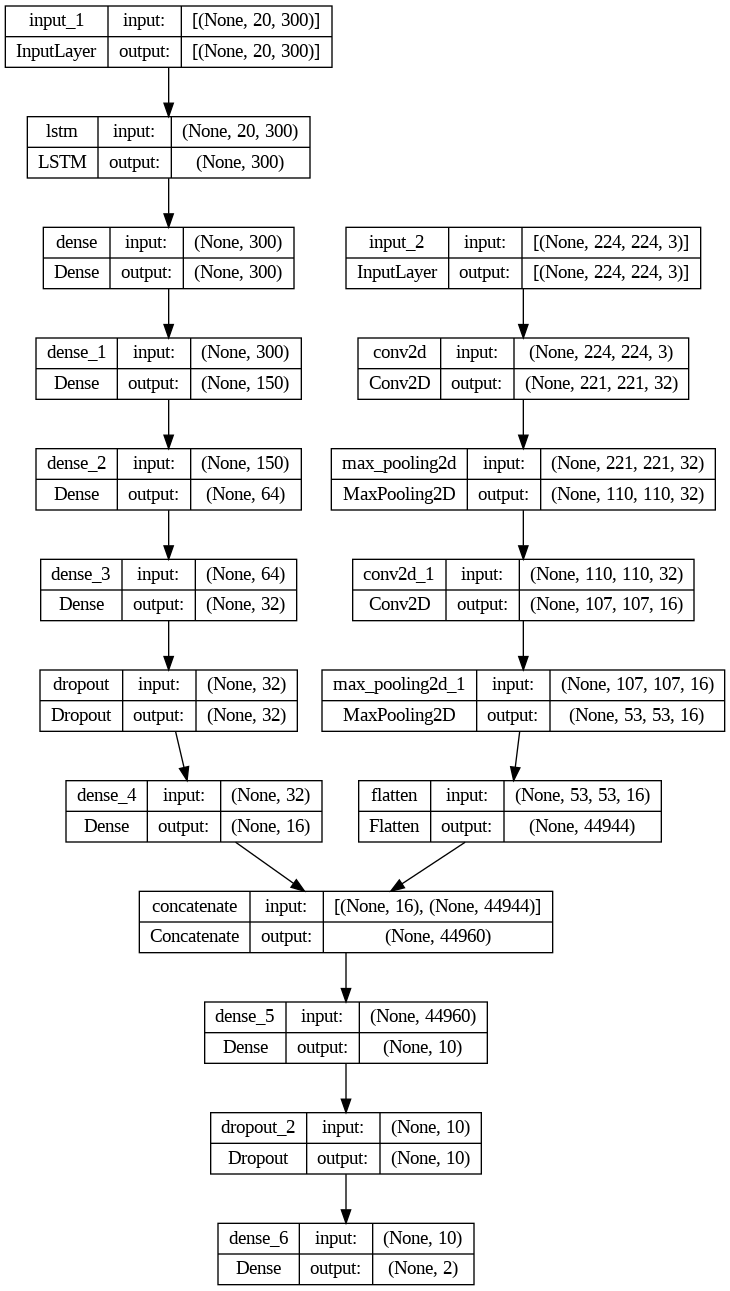

In [16]:
# Tweet input model
visible11 = Input(shape=(20,300))
hidden11 = LSTM(300, activation='relu', dropout=.5, recurrent_dropout=.2, return_sequences=False)(visible11)
hidden12 = Dense(300, activation='relu')(hidden11)
hidden13 = Dense(150, activation='relu')(hidden12)
hidden14 = Dense(64, activation='relu')(hidden13)
hidden15 = Dense(32, activation='relu')(hidden14)
drop11 = Dropout(.5)(hidden15)
hidden16 = Dense(16, activation='relu')(drop11)
 
# Image input model
visible21 = Input(shape=(224,224,3))
conv22 = Conv2D(32, kernel_size=4, activation='relu')(visible21)
pool22 = MaxPooling2D(pool_size=(2, 2))(conv22)
conv23 = Conv2D(16, kernel_size=4 , activation='relu')(pool22)
pool23 = MaxPooling2D(pool_size=(2, 2))(conv23)
drop21 = Dropout(.5)(pool23)
flat21 = Flatten()(pool23)

# merge input models
merge11 = concatenate([hidden16, flat21])

# interpretation model
hidden32 = Dense(10, activation='sigmoid')(merge11)
drop31 = Dropout(.5)(hidden32)
output = Dense(2, activation='softmax')(drop31)


model = Model(inputs=[visible11, visible21], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit([t_tweets_enum,t_images],y,
          validation_data=([ts_tweets_enum,ts_images],ty), 
                           callbacks=[monitor],verbose=2, epochs=100)  

m_pred = model.predict([ts_tweets_enum,ts_images])
m_pred = np.argmax(m_pred,axis=1)
y_true=np.argmax(ty,axis=1)
print(classification_report(y_true, m_pred))
# summarize layers
print(model.summary())
# plot graph
plot_model(model, show_shapes=True)

Transfer Learning Multi Input Model With Word2Vec and VGG16

Epoch 1/100
31/31 - 10s - loss: 0.4756 - val_loss: 0.6062 - 10s/epoch - 326ms/step
Epoch 2/100
31/31 - 6s - loss: 0.3067 - val_loss: 0.5726 - 6s/epoch - 188ms/step
Epoch 3/100
31/31 - 6s - loss: 0.2577 - val_loss: 0.6201 - 6s/epoch - 181ms/step
Epoch 4/100
31/31 - 6s - loss: 0.2266 - val_loss: 0.7352 - 6s/epoch - 196ms/step
Epoch 5/100
31/31 - 6s - loss: 0.2129 - val_loss: 0.6255 - 6s/epoch - 183ms/step
Epoch 6/100
31/31 - 6s - loss: 0.1933 - val_loss: 0.5810 - 6s/epoch - 183ms/step
Epoch 7/100
31/31 - 6s - loss: 0.1899 - val_loss: 0.6659 - 6s/epoch - 197ms/step
Epoch 7: early stopping
14/14 [==============================] - 2s 122ms/step
              precision    recall  f1-score   support

           0       0.79      0.71      0.74       146
           1       0.85      0.90      0.87       274

    accuracy                           0.83       420
   macro avg       0.82      0.80      0.81       420
weighted avg       0.83      0.83      0.83       420

Model: "model_5"
________

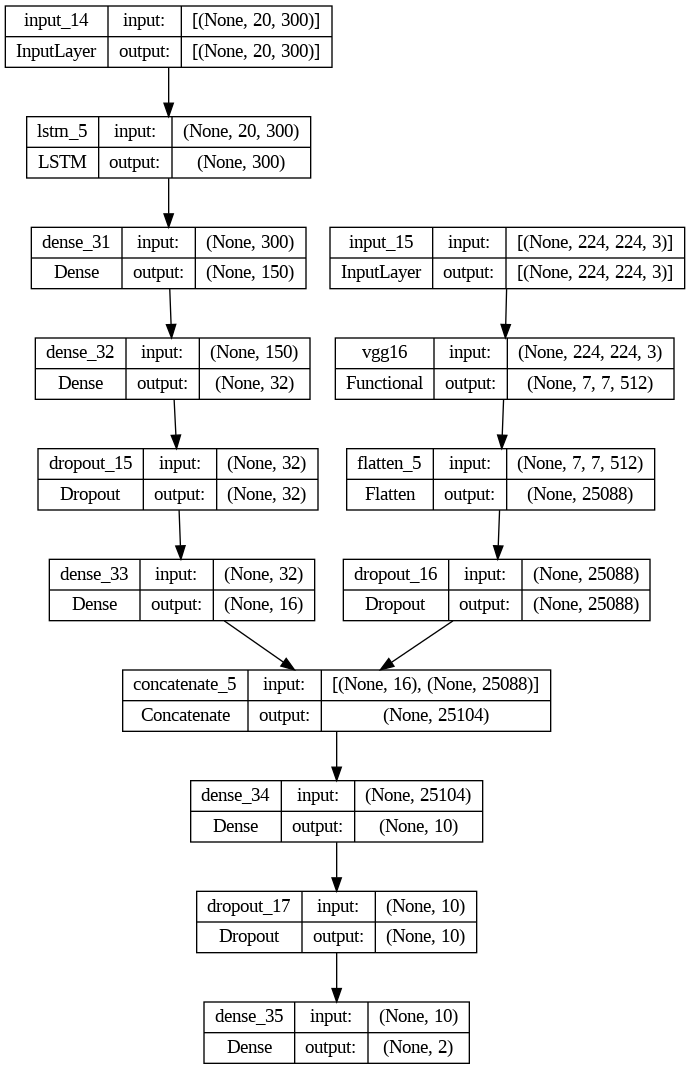

In [25]:
# Tweet input model
visible11 = Input(shape=(20,300))
hidden11 = LSTM(300, activation='relu', dropout=.5, return_sequences=False)(visible11)
hidden13 = Dense(150, activation='relu')(hidden11)
hidden15 = Dense(32, activation='relu')(hidden13)
drop11 = Dropout(.5)(hidden15)
hidden16 = Dense(16, activation='relu')(drop11)

# Image input model
visible21 = Input(shape=(224,224,3))
vgg_model21 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
vgg_model21.trainable = False
hidden21 = vgg_model21(visible21)
flat21 = Flatten()(hidden21)
drop21 = Dropout(.5)(flat21)

# merge input models
merge11 = concatenate([hidden16, drop21])

# interpretation model
hidden32 = Dense(10, activation='sigmoid')(merge11)
drop31 = Dropout(.5)(hidden32)
output = Dense(2, activation='softmax')(drop31)

model = Model(inputs=[visible11, visible21], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit([t_tweets_enum,t_images],y,
          validation_data=([ts_tweets_enum,ts_images],ty), 
                           callbacks=[monitor],verbose=2, epochs=100)  

m_pred = model.predict([ts_tweets_enum,ts_images])
m_pred = np.argmax(m_pred,axis=1)
y_true=np.argmax(ty,axis=1)
print(classification_report(y_true, m_pred))
# summarize layers
print(model.summary())
# plot graph
plot_model(model, show_shapes=True)

Transfer Learning Multi Input Model With BERT

In [26]:
%pip install transformers
%pip install -U sentence-transformers

import torch
from transformers import BertModel
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
t_tweets_enum = model.encode(train_tweets['tweetText'].values)
ts_tweets_enum = model.encode(test_tweets['tweetText'].values)

In [28]:
print(ts_tweets_enum.shape)
t_tweets_enum = t_tweets_enum[:,:,np.newaxis]
ts_tweets_enum = ts_tweets_enum[:,:,np.newaxis]

(420, 384)


Epoch 1/100
31/31 - 86s - loss: 0.6774 - val_loss: 0.5267 - 86s/epoch - 3s/step
Epoch 2/100
31/31 - 55s - loss: 0.5958 - val_loss: 0.5192 - 55s/epoch - 2s/step
Epoch 3/100
31/31 - 62s - loss: 0.5328 - val_loss: 0.4515 - 62s/epoch - 2s/step
Epoch 4/100
31/31 - 57s - loss: 0.4509 - val_loss: 0.4584 - 57s/epoch - 2s/step
Epoch 5/100
31/31 - 56s - loss: 0.4174 - val_loss: 0.4324 - 56s/epoch - 2s/step
Epoch 6/100
31/31 - 56s - loss: 0.3979 - val_loss: 0.4079 - 56s/epoch - 2s/step
Epoch 7/100
31/31 - 55s - loss: 0.3426 - val_loss: 0.4714 - 55s/epoch - 2s/step
Epoch 8/100
31/31 - 56s - loss: 0.2797 - val_loss: 0.4189 - 56s/epoch - 2s/step
Epoch 9/100
31/31 - 57s - loss: 0.2533 - val_loss: 0.3917 - 57s/epoch - 2s/step
Epoch 10/100
31/31 - 54s - loss: 0.2225 - val_loss: 0.4245 - 54s/epoch - 2s/step
Epoch 11/100
31/31 - 56s - loss: 0.1988 - val_loss: 0.4751 - 56s/epoch - 2s/step
Epoch 12/100
31/31 - 54s - loss: 0.1888 - val_loss: 0.3538 - 54s/epoch - 2s/step
Epoch 13/100
31/31 - 56s - loss: 0.16

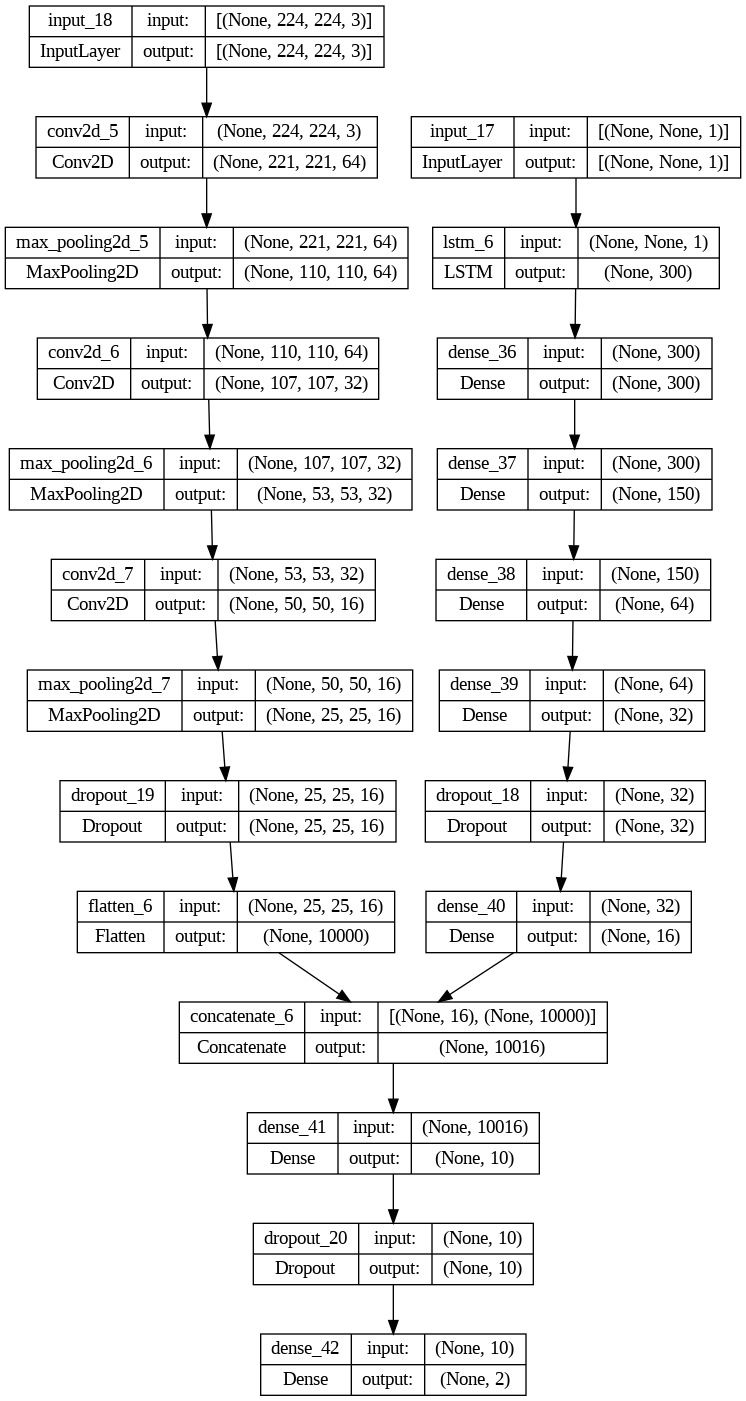

In [29]:
# Tweet input model
visible11 = Input(shape=(None,1))
hidden11 = LSTM(300, activation='relu', dropout=.5,recurrent_dropout=.2, return_sequences=False)(visible11)
hidden12 = Dense(300, activation='relu')(hidden11)
hidden13 = Dense(150, activation='relu')(hidden12)
hidden14 = Dense(64, activation='relu')(hidden13)
hidden15 = Dense(32, activation='relu')(hidden14)
drop11 = Dropout(.5)(hidden15)
hidden16 = Dense(16, activation='relu')(drop11)
 
# Image input model
visible21 = Input(shape=(224,224,3))
conv21 = Conv2D(64, kernel_size=4, activation='relu')(visible21)
pool21 = MaxPooling2D(pool_size=(2, 2))(conv21)
conv22 = Conv2D(32, kernel_size=4, activation='relu')(pool21)
pool22 = MaxPooling2D(pool_size=(2, 2))(conv22)
conv23 = Conv2D(16, kernel_size=4 , activation='relu')(pool22)
pool23 = MaxPooling2D(pool_size=(2, 2))(conv23)
drop21 = Dropout(.5)(pool23)
flat21 = Flatten()(drop21)

# merge input models
merge11 = concatenate([hidden16, flat21])

# interpretation model
hidden32 = Dense(10, activation='sigmoid')(merge11)
drop31 = Dropout(.5)(hidden32)
output = Dense(2, activation='softmax')(drop31)


model = Model(inputs=[visible11, visible21], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit([t_tweets_enum,t_images],y,
          validation_data=([ts_tweets_enum,ts_images],ty), 
                           callbacks=[monitor],verbose=2, epochs=100)  

m_pred = model.predict([ts_tweets_enum,ts_images])
m_pred = np.argmax(m_pred,axis=1)
y_true=np.argmax(ty,axis=1)
print(classification_report(y_true, m_pred))
# summarize layers
print(model.summary())
# plot graph
plot_model(model, show_shapes=True)

Transfer Learning Multi Input Model With BERT and VGG16

Epoch 1/100
31/31 - 64s - loss: 0.4477 - val_loss: 0.6891 - 64s/epoch - 2s/step
Epoch 2/100
31/31 - 53s - loss: 0.2532 - val_loss: 0.5638 - 53s/epoch - 2s/step
Epoch 3/100
31/31 - 56s - loss: 0.1986 - val_loss: 0.6629 - 56s/epoch - 2s/step
Epoch 4/100
31/31 - 55s - loss: 0.1619 - val_loss: 0.6581 - 55s/epoch - 2s/step
Epoch 5/100
31/31 - 55s - loss: 0.1466 - val_loss: 0.6361 - 55s/epoch - 2s/step
Epoch 6/100
31/31 - 56s - loss: 0.1273 - val_loss: 0.6251 - 56s/epoch - 2s/step
Epoch 7/100
31/31 - 53s - loss: 0.1180 - val_loss: 0.5994 - 53s/epoch - 2s/step
Epoch 7: early stopping
14/14 [==============================] - 4s 244ms/step
              precision    recall  f1-score   support

           0       0.73      0.51      0.60       146
           1       0.77      0.90      0.83       274

    accuracy                           0.76       420
   macro avg       0.75      0.70      0.72       420
weighted avg       0.76      0.76      0.75       420

Model: "model_8"
_________________

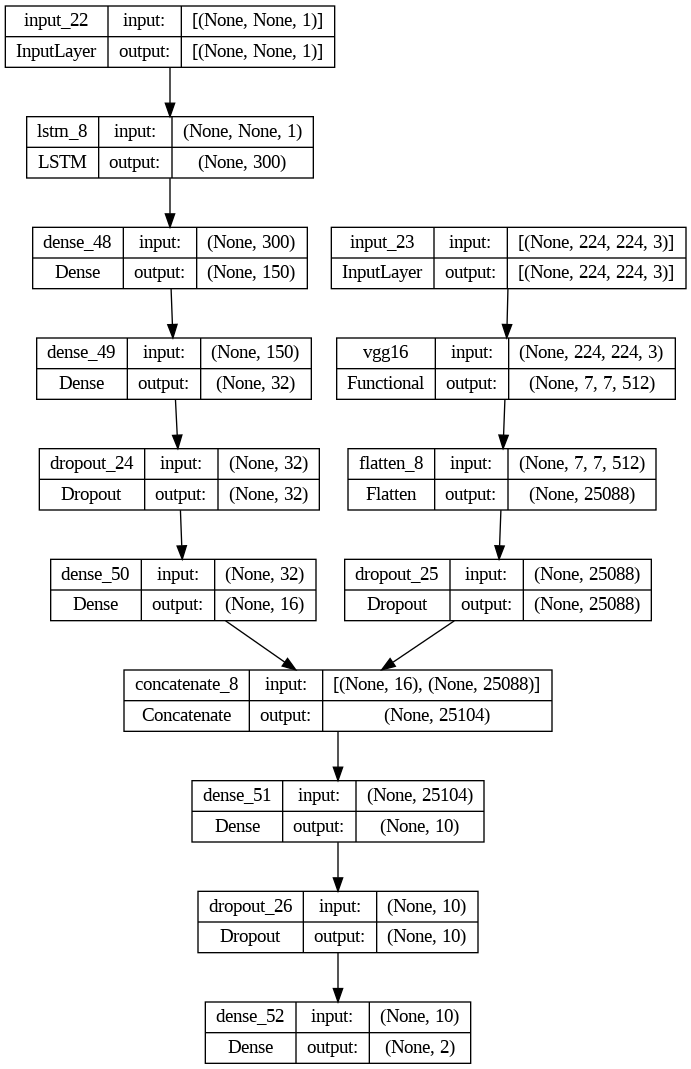

In [31]:
#Tweet input model
visible11 = Input(shape=(None,1))
hidden11 = LSTM(300, activation='relu', dropout=.5,recurrent_dropout=.2, return_sequences=False)(visible11)
hidden13 = Dense(150, activation='relu')(hidden11)
hidden15 = Dense(32, activation='relu')(hidden13)
drop11 = Dropout(.5)(hidden15)
hidden16 = Dense(16, activation='relu')(drop11)

# Image input model
visible21 = Input(shape=(224,224,3))
vgg_model21 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
vgg_model21.trainable = False
hidden21 = vgg_model21(visible21)
flat21 = Flatten()(hidden21)
drop21 = Dropout(.5)(flat21)

# merge input models
merge11 = concatenate([hidden16, drop21])

# interpretation model
hidden32 = Dense(10, activation='sigmoid')(merge11)
drop31 = Dropout(.5)(hidden32)
output = Dense(2, activation='softmax')(drop31)

model = Model(inputs=[visible11, visible21], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit([t_tweets_enum,t_images],y,
          validation_data=([ts_tweets_enum,ts_images],ty), 
                           callbacks=[monitor],verbose=2, epochs=100)  

m_pred = model.predict([ts_tweets_enum,ts_images])
m_pred = np.argmax(m_pred,axis=1)
y_true=np.argmax(ty,axis=1)
print(classification_report(y_true, m_pred))
# summarize layers
print(model.summary())
# plot graph
plot_model(model, show_shapes=True)